In [1]:
%pip install -U -q segmentation-models
%pip install -q tensorflow==2.12.0
# %pip install -q tensorflow-gpu-base==2.12.0
%pip install -q keras==2.12.0

import os
from  importlib import reload # for refreshing import(nets.py)
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
import nets 

# tf.compat.v1.enable_eager_execution()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2023-05-16 12:59:17.380172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 12:59:17.407353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 12:59:17.408071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [2]:
from tensorflow.python.client import device_lib
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4"

print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12145730904032967180
xla_global_id: -1
]
[]
True


2023-05-16 12:59:18.701912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-05-16 12:59:18.701931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: Blackwing-Alienware
2023-05-16 12:59:18.701935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: Blackwing-Alienware
2023-05-16 12:59:18.701963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-05-16 12:59:18.701974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-05-16 12:59:18.701977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [3]:
%pip install imutils

import re
import cv2

import numpy as np
import matplotlib.pyplot as plt

# generate
from imutils import rotate_bound
from math import ceil
from random import randint, shuffle

# files
from utils import *

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load the dataset

train_data_path= "../../data/imgs/wafer/in/"
wafer_img_paths=[]
for root, dirs, files in os.walk(train_data_path):
    for name in files:
        if re.findall('.jpg', name):
            wafer_img_paths.append(root+name)
    break
            
if not wafer_img_paths:
    print("err loading ",train_data_path)
else:
    print(len(wafer_img_paths))

101


In [5]:
def imgPath2masks(dataset_path,threshold=110,kernelSize=5,savepath=""):
    for imgPath in wafer_img_paths:
        if re.findall('.jpg$', imgPath)  :
            path,ext  = os.path.splitext(imgPath)
            file = os.path.basename(path)
            dirPath = os.path.dirname(path)
            
            if savepath == "":
                savepath = os.path.join(dirPath,"GT",file + ext)
    #         print(savepath)

            image = cv2.imread(imgPath)
            imageMask = getMask(image,threshold=threshold,kernelSize=kernelSize) 
            imgContours = img2segmented(imageMask,savepath)

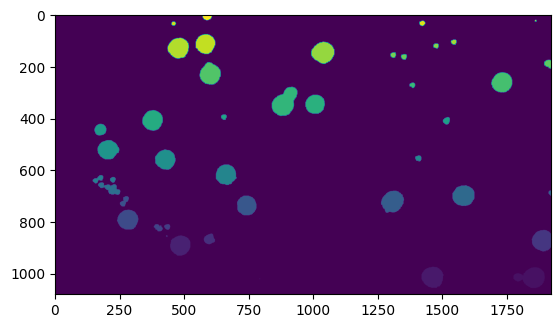

45
(1080, 1920)


In [6]:
image = cv2.imread(wafer_img_paths[0])
imageMask = getMask(image,threshold=100,kernelSize=5) 
# listContours = markContours(imageMask) 
imgContours = img2segmented(imageMask)

plt.imshow(imgContours)
plt.show()
a=np.unique(imgContours)
print(len(a))
print(imgContours.shape)
# TODO check 32.jpg

In [7]:

reload(nets)

batch_size=2
ds=[]
targets=[]
for idx, img in enumerate(wafer_img_paths):
    if idx >= batch_size:
        break
        
    image = cv2.imread(img)
    imgContours = img2segmented(getMask(image,threshold=100,kernelSize=5) )
    
    ds.append(image)
    targets.append(imgContours)
dataS=np.array(ds)
targetS=np.array(targets)

input_shape = dataS.shape[1:]# (4, 1080, 1920, 3)
Dataset = tf.convert_to_tensor(dataS/255)
Targets = tf.convert_to_tensor(targetS/255)
                     
model= nets.dummy_model(input_shape)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(Dataset, Targets, batch_size = 1, epochs = 5, shuffle = True, verbose = 1)

y= model(Dataset)
im = y.numpy()
print("model output shape:",im.shape)
tf.device(
    device_name
)

for immg in im:
    immg.squeeze()
    plt.imshow(immg)
    plt.show()


Epoch 1/5


2023-05-16 12:53:12.909867: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 57870030000 exceeds 10% of free system memory.
2023-05-16 12:53:12.909907: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_grad_input_ops.h:591 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[1,1929001,7500] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
2023-05-16 12:53:12.909920: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[1,1929001,7500] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node sequential/conv2d_transpose/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv2d_transpose/conv2d_transpose' defined at (most recent call last):
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/kristina/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/kristina/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/kristina/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/kristina/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/kristina/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/kristina/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/kristina/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/kristina/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/kristina/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/kristina/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/kristina/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/kristina/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/kristina/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/kristina/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/kristina/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/kristina/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_39747/2936967960.py", line 24, in <module>
      model.fit(Dataset, Targets, batch_size = 1, epochs = 5, shuffle = True, verbose = 1)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "/home/kristina/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/backend.py", line 6149, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'sequential/conv2d_transpose/conv2d_transpose'
OOM when allocating tensor with shape[1,1929001,7500] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node sequential/conv2d_transpose/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1148]

In [ ]:

model = UNet(
    enc_chs=(3, 8, 16, 32),
    dec_chs=(32, 16, 8),
    num_class=1,
    retain_dim=True,
    out_sz=(480, 640)
).to(device)

In [ ]:
# print(train_data_path)
# train_data_path =os.path.dirname(train_data_path)
# GROUND_MASK_DIR_PATH = train_data_path
# GROUND_MASK_DIR_PATH = os.path.join(os.path.dirname(train_data_path),"GT")


In [ ]:

# batch_size=8
# X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
# train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
# valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)
# x_train, y_train, x_test, y_test=load_data(train_data_path)
# print(train_data_path)

In [ ]:

# The_Model = nets.Baseline_Model(Raman_Points, num_classes)
The_Model = Baseline_Model(X_train[0].shape, 255)

test_data  = test_dataset[:, 1:] 
test_labels  = test_dataset[:, :1].astype(int) 

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [ ]:

# contours = cv2.findContours(imageMask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # img, contours, hierarchy
# contoutrsOnImgs=[]
# for i,cnt in enumerate(contours[0]): # iterate through contours
#     if i > 0:  # skip background
#         contour = cnt.squeeze()
#         image0 = np.zeros(image.shape, dtype=np.uint8)
#         contoursImg = cv2.drawContours(image0, contours[0],i,(255,255,255), thickness=cv2.FILLED)
#         plt.imshow(contoursImg)
#         plt.show()
# #         cv.drawContours(image0 = np.zeros(image, dtype=np.uint8) 
# #         img=contour2img(image,contours,savePath="./demo/imgs"+str(i)+".jpg")      

# plot_intensity_histogram(image) 

In [ ]:
# %pip install pixellib
import pixellib
from pixellib.custom_train import instance_custom_training
                     
train_maskrcnn = instance_custom_training()
train_maskrcnn.modelConfig(network_backbone = "resnet101", num_classes= 2, batch_size = 4)
train_maskrcnn.load_pretrained_model("mask_rcnn_coco.h5")
train_maskrcnn.load_dataset("Nature")
train_maskrcnn.train_model(num_epochs = 5, augmentation=True,  path_trained_models = "mask_rcnn_models")